In [1]:
import os
import re

os.chdir("../..")

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.interpolate import griddata

from gala.Galab import llaplace

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Burgers Equation

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \frac{0.01}{\pi}\frac{\partial^{2} u}{\partial x^{2}}=0$$
$$u(x,0) = -sin( \pi x),  u(-1,t)=u(1,t)=0$$

## Feed Forward Neural Network

In [2]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        out[:,1] = torch.log(1 + torch.exp(out[:,1])) + 1e-06
        return out

## Parametric PINN for Inverse Problems

In [3]:
def de(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)
    
    du = torch.autograd.grad(
        u[:,0], data_domain, 
        grad_outputs=torch.ones_like(u[:,0]),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = du[:,1].reshape(-1,1) + u[:,0].reshape(-1,1)*du[:,0].reshape(-1,1) - data_domain[:,2].reshape(-1,1)*ddu_x[:,0].reshape(-1,1)

    return torch.cat([f,u[:,1].reshape(-1,1)], axis = 1)

def ini_c(self,data_inic):
    u = self(data_inic)
    return torch.cat([u[:,0].reshape(-1,1) + torch.sin(torch.pi*data_inic[:,0].reshape(-1,1)),u[:,1].reshape(-1,1)], axis = 1)

def left_bc(self,data_lbc):
    u = self(data_lbc)
    return u

def right_bc(self,data_rbc):
    u = self(data_rbc)
    return u

In [4]:
DNN.de = de
DNN.ini_c = ini_c
DNN.left_bc = left_bc
DNN.right_bc = right_bc

In [5]:
def samples_space(size,maxl=1):
    t_f_train = lhs(2, size)*maxl
    t_f_train[:,0] = t_f_train[:,0]*(2)-1
    t_f_train[:,1] = t_f_train[:,1]*(0.5)
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [6]:
def data_pde(size,minp,maxp):

    xy, param = samples_space(size),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    ini_c = torch.cat([x,torch.zeros_like(x).float(),param],axis = 1).float()

    left_bc = torch.cat([torch.ones_like(x).float()*(-1),y, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(),y, param],axis = 1).float()

    return pde_domain,ini_c,left_bc,right_bc

In [7]:
def train_adam(pinn,optimizer,epochs, sample_size = 100, minval_param = 0.2,maxval_param = 2,repetitions=1):
      print("Starting Adam Training")
      train_loss=[]
      for i in range(epochs):
        pde_domain,ini_c,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
        
        pde_domain,ini_c = Variable(pde_domain,requires_grad=True),Variable(ini_c,requires_grad=True)
        left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
        
        for _ in range(repetitions):
                optimizer.zero_grad()

                pde_pred,ini_c_pred = pinn.de(pde_domain), pinn.ini_c(ini_c)
                left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

                loss_pde = torch.mean(0.5*torch.log(pde_pred[:,1].reshape(-1,1)) + (pde_pred[:,0].reshape(-1,1)**2) / (2*pde_pred[:,1].reshape(-1,1)))
                loss_ini = torch.mean(0.5*torch.log(ini_c_pred[:,1].reshape(-1,1)) + (ini_c_pred[:,0].reshape(-1,1)**2) / (2*ini_c_pred[:,1].reshape(-1,1)))
                loss_lbc = torch.mean(0.5*torch.log(left_bc_pred[:,1].reshape(-1,1)) + (left_bc_pred[:,0].reshape(-1,1)**2) / (2*left_bc_pred[:,1].reshape(-1,1)))
                loss_rbc = torch.mean(0.5*torch.log(right_bc_pred[:,1].reshape(-1,1)) + (right_bc_pred[:,0].reshape(-1,1)**2) / (2*right_bc_pred[:,1].reshape(-1,1)))

                Loss =  loss_pde + loss_ini + loss_lbc + loss_rbc + 10
                train_loss.append(Loss.item())
                if i % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_PDE: %.5e, Loss_ini: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                                                         Loss.item(),loss_pde.item(),loss_ini.item(), loss_lbc.item(), loss_rbc.item()))
                                
                Loss.backward() 

                optimizer.step() 

                #sheduler.step()
      return train_loss

In [8]:
def train_LBFGS(pinn,optimizer, sample_size = 100,minval_param = 0.2,maxval_param = 2):
    print("Starting Training: LBFGS optimizer")
    train_loss=[]

    pde_domain,ini_c,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
    
    pde_domain,ini_c = Variable(pde_domain,requires_grad=True),Variable(ini_c,requires_grad=True)
    left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
    
    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred,ini_c_pred = pinn.de(pde_domain), pinn.ini_c(ini_c)
        left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

        loss_pde = torch.mean(0.5*torch.log(pde_pred[:,1].reshape(-1,1)) + (pde_pred[:,0].reshape(-1,1)**2) / (2*pde_pred[:,1].reshape(-1,1)))
        loss_ini = torch.mean(0.5*torch.log(ini_c_pred[:,1].reshape(-1,1)) + (ini_c_pred[:,0].reshape(-1,1)**2) / (2*ini_c_pred[:,1].reshape(-1,1)))
        loss_lbc = torch.mean(0.5*torch.log(left_bc_pred[:,1].reshape(-1,1)) + (left_bc_pred[:,0].reshape(-1,1)**2) / (2*left_bc_pred[:,1].reshape(-1,1)))
        loss_rbc = torch.mean(0.5*torch.log(right_bc_pred[:,1].reshape(-1,1)) + (right_bc_pred[:,0].reshape(-1,1)**2) / (2*right_bc_pred[:,1].reshape(-1,1)))

        Loss =  loss_pde + loss_ini + loss_lbc + loss_rbc + 10
        train_loss.append(Loss.item())

        print('Loss: %.5e, Loss_PDE: %.5e, Loss_ini: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                                            Loss.item(),loss_pde.item(),loss_ini.item(), loss_lbc.item(), loss_rbc.item()))

        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 
    return train_loss

In [9]:
# Number of observations
epochs = 5000
nobs = 3500
lr = 0.01

min_param , max_param = 0.0001, 0.05

layers = [3] + 3*[40] + [2]

model = DNN(layers)
#loss = torch.nn.MSELoss(reduction ='mean')
# model.load_state_dict(torch.load(f"../Projects-1/Physics _Informed_NN/GaLA/Gala_models/BurgEq_4_30.pt"))
# model.eval()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_history = train_adam(model,optimizer,epochs, nobs,min_param,max_param)

optimizer = torch.optim.LBFGS(
    model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" )

loss_history_b = train_LBFGS(model,optimizer, nobs,min_param,max_param)

Starting Adam Training
Iter 0, Loss: 9.49793e+00, Loss_PDE: -2.23884e-01, Loss_ini: 1.59960e-01, Loss_lbc: -1.98742e-01,Loss_rbc: -2.39403e-01


Iter 10, Loss: 7.55484e+00, Loss_PDE: -1.03710e+00, Loss_ini: 4.49194e-01, Loss_lbc: -9.84994e-01,Loss_rbc: -8.72262e-01
Iter 20, Loss: 7.09946e+00, Loss_PDE: -1.30506e+00, Loss_ini: 8.61236e-01, Loss_lbc: -1.30772e+00,Loss_rbc: -1.14901e+00
Iter 30, Loss: 4.52530e+00, Loss_PDE: -1.90350e+00, Loss_ini: 5.78435e-01, Loss_lbc: -2.00969e+00,Loss_rbc: -2.13995e+00
Iter 40, Loss: 3.00293e+00, Loss_PDE: -2.41140e+00, Loss_ini: 2.82340e-01, Loss_lbc: -2.44428e+00,Loss_rbc: -2.42373e+00
Iter 50, Loss: 1.61272e+00, Loss_PDE: -2.79869e+00, Loss_ini: 1.46066e-01, Loss_lbc: -2.86730e+00,Loss_rbc: -2.86736e+00
Iter 60, Loss: 1.41851e+00, Loss_PDE: -2.42102e+00, Loss_ini: 2.37491e-01, Loss_lbc: -3.17983e+00,Loss_rbc: -3.21813e+00
Iter 70, Loss: 8.73799e+00, Loss_PDE: 7.96736e-01, Loss_ini: 6.13710e-01, Loss_lbc: -1.34534e+00,Loss_rbc: -1.32712e+00
Iter 80, Loss: 6.27917e+00, Loss_PDE: -1.16224e+00, Loss_ini: 1.45532e-01, Loss_lbc: -1.44185e+00,Loss_rbc: -1.26228e+00
Iter 90, Loss: 6.62437e+00, Loss_

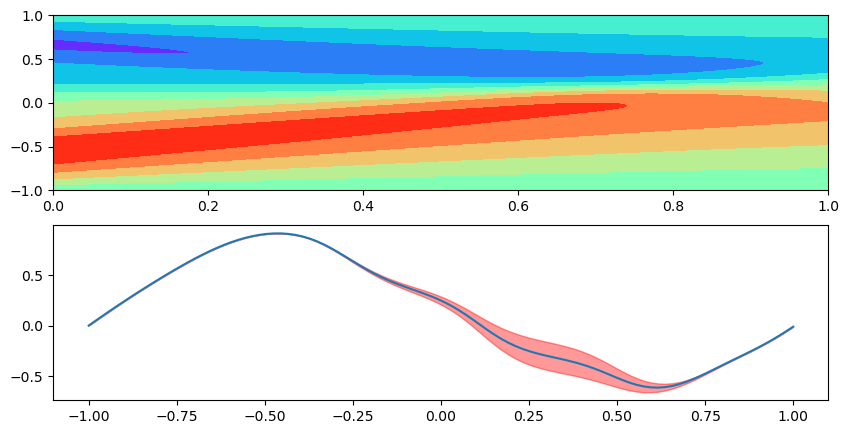

In [11]:
x = np.linspace(-1,1,100)
y = np.linspace(0,1,100)

xx, yy = np.meshgrid(x, y)
xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()


X_star = torch.cat([xx,yy,torch.ones_like(xx)*(0.005)],axis = 1)
znn = model(X_star)

fig, axs = plt.subplots(2,1, figsize=(10, 5))

xx,yy = np.meshgrid(x, y)

U_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), znn[:,0].detach().numpy().flatten(), (xx,yy), method='cubic')
U_sigma = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), znn[:,1].detach().numpy().flatten(), (xx,yy), method='cubic')

axs[0].contourf(y.flatten(), x.flatten(), U_pred.T,cmap='rainbow')
axs[1].plot(x,U_pred[10,:])
axs[1].fill_between(x.reshape(-1), U_pred[10,:]+U_sigma[10,:],U_pred[10,:]-U_sigma[10,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


## Heat Equation

$$\frac{\partial u}{\partial t} = k \frac{\partial^{2} u}{\partial x^{2}} + sin(5 \pi x)$$
$$u(x,0) = 4sin(3 \pi x)+ 9sin(7 \pi x),  u(0,t)=u(1,t)=0$$

In [28]:
def exact_solution(x,t,theta):
    u = 4*np.sin(3*np.pi*x)*np.exp(-theta*((3*np.pi)**2)*t) + 9*np.sin(7*np.pi*x)*np.exp(-theta*((7*np.pi)**2)*t) + \
    (1/(25*(np.pi**2)*theta))*np.sin(5*np.pi*x)*np.exp(-theta*((5*np.pi)**2)*t) - (1/(25*(np.pi**2)*theta))*np.sin(5*np.pi*x)
    return u    

In [30]:
def de_heat(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)
    
    du = torch.autograd.grad(
        u[:,0], data_domain, 
        grad_outputs=torch.ones_like(u[:,0]),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = du[:,1].reshape(-1,1) - data_domain[:,2].reshape(-1,1)*ddu_x[:,0].reshape(-1,1)- torch.sin(5*torch.pi*data_domain[:,0].reshape(-1,1))

    return torch.cat([f,u[:,1].reshape(-1,1)], axis = 1)

def ini_c_heat(self,data_inic):
    u = self(data_inic)
    unic = u[:,0].reshape(-1,1) - 4*torch.sin(3*torch.pi*data_inic[:,0].reshape(-1,1)) - 9*torch.sin(7*torch.pi*data_inic[:,0].reshape(-1,1))
    return torch.cat([unic,u[:,1].reshape(-1,1)], axis = 1)

def left_bc_heat(self,data_lbc):
    u = self(data_lbc)
    return u

def right_bc_heat(self,data_rbc):
    u = self(data_rbc)
    return u

In [31]:
DNN.de_heat = de_heat
DNN.ini_c_heat = ini_c_heat
DNN.left_bc_heat = left_bc_heat
DNN.right_bc_heat = right_bc_heat

In [32]:
def samples_space(size,maxl=1):
    t_f_train = lhs(2, size)*maxl
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [33]:
def data_pde_heat(size,minp,maxp):

    xy, param = samples_space(size),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    ini_c = torch.cat([x,torch.zeros_like(x).float(),param],axis = 1).float()

    left_bc = torch.cat([torch.zeros_like(x).float(),y, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(),y, param],axis = 1).float()

    return pde_domain,ini_c,left_bc,right_bc

In [34]:
def train_adam(pinn,optimizer,epochs, sample_size = 100, minval_param = 0.2,maxval_param = 2,repetitions=1):
      print("Starting Adam Training")
      train_loss=[]
      for i in range(epochs):
        pde_domain,ini_c,left_bc,right_bc = data_pde_heat(sample_size,minval_param,maxval_param)
        
        pde_domain,ini_c = Variable(pde_domain,requires_grad=True),Variable(ini_c,requires_grad=True)
        left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
        
        for _ in range(repetitions):
                optimizer.zero_grad()

                pde_pred,ini_c_pred = pinn.de_heat(pde_domain), pinn.ini_c_heat(ini_c)
                left_bc_pred,right_bc_pred = pinn.left_bc_heat(left_bc),pinn.right_bc_heat(right_bc)

                loss_pde = torch.mean(0.5*torch.log(pde_pred[:,1].reshape(-1,1)) + (pde_pred[:,0].reshape(-1,1)**2) / (2*pde_pred[:,1].reshape(-1,1)))
                loss_ini = torch.mean(0.5*torch.log(ini_c_pred[:,1].reshape(-1,1)) + (ini_c_pred[:,0].reshape(-1,1)**2) / (2*ini_c_pred[:,1].reshape(-1,1)))
                loss_lbc = torch.mean(0.5*torch.log(left_bc_pred[:,1].reshape(-1,1)) + (left_bc_pred[:,0].reshape(-1,1)**2) / (2*left_bc_pred[:,1].reshape(-1,1)))
                loss_rbc = torch.mean(0.5*torch.log(right_bc_pred[:,1].reshape(-1,1)) + (right_bc_pred[:,0].reshape(-1,1)**2) / (2*right_bc_pred[:,1].reshape(-1,1)))

                Loss =  loss_pde + loss_ini + loss_lbc + loss_rbc + 10
                train_loss.append(Loss.item())
                if i % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_PDE: %.5e, Loss_ini: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                                                         Loss.item(),loss_pde.item(),loss_ini.item(), loss_lbc.item(), loss_rbc.item()))
                                
                Loss.backward() 

                optimizer.step() 

                #sheduler.step()
      return train_loss

In [35]:
def train_LBFGS(pinn,optimizer, sample_size = 100,minval_param = 0.2,maxval_param = 2):
    print("Starting Training: LBFGS optimizer")
    train_loss=[]

    pde_domain,ini_c,left_bc,right_bc = data_pde_heat(sample_size,minval_param,maxval_param)
    
    pde_domain,ini_c = Variable(pde_domain,requires_grad=True),Variable(ini_c,requires_grad=True)
    left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
    
    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred,ini_c_pred = pinn.de_heat(pde_domain), pinn.ini_c_heat(ini_c)
        left_bc_pred,right_bc_pred = pinn.left_bc_heat(left_bc),pinn.right_bc_heat(right_bc)

        loss_pde = torch.mean(0.5*torch.log(pde_pred[:,1].reshape(-1,1)) + (pde_pred[:,0].reshape(-1,1)**2) / (2*pde_pred[:,1].reshape(-1,1)))
        loss_ini = torch.mean(0.5*torch.log(ini_c_pred[:,1].reshape(-1,1)) + (ini_c_pred[:,0].reshape(-1,1)**2) / (2*ini_c_pred[:,1].reshape(-1,1)))
        loss_lbc = torch.mean(0.5*torch.log(left_bc_pred[:,1].reshape(-1,1)) + (left_bc_pred[:,0].reshape(-1,1)**2) / (2*left_bc_pred[:,1].reshape(-1,1)))
        loss_rbc = torch.mean(0.5*torch.log(right_bc_pred[:,1].reshape(-1,1)) + (right_bc_pred[:,0].reshape(-1,1)**2) / (2*right_bc_pred[:,1].reshape(-1,1)))

        Loss =  loss_pde + loss_ini + loss_lbc + loss_rbc + 10
        train_loss.append(Loss.item())

        print('Loss: %.5e, Loss_PDE: %.5e, Loss_ini: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                                            Loss.item(),loss_pde.item(),loss_ini.item(), loss_lbc.item(), loss_rbc.item()))

        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 
    return train_loss

In [36]:
epochs = 5000
nobs = 3000
lr = 0.01

min_param , max_param = 0.0001, 0.05

layers = [3] + 3*[40] + [2]
model_heat = DNN(layers)

In [37]:
optimizer = torch.optim.Adam(model_heat.parameters(), lr = lr)

loss_history = train_adam(model_heat,optimizer,epochs, nobs,min_param,max_param)

# optimizer = torch.optim.LBFGS(
#     model_heat.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" )

# loss_history_b = train_LBFGS(model_heat,optimizer, nobs,min_param,max_param)

Starting Adam Training
Iter 0, Loss: 4.84986e+01, Loss_PDE: 1.53852e-01, Loss_ini: 3.88001e+01, Loss_lbc: -2.19925e-01,Loss_rbc: -2.35497e-01


Iter 10, Loss: 1.80128e+01, Loss_PDE: 8.47826e-01, Loss_ini: 5.54191e+00, Loss_lbc: 8.06137e-01,Loss_rbc: 8.16948e-01
Iter 20, Loss: 1.73192e+01, Loss_PDE: 1.00857e+00, Loss_ini: 4.30141e+00, Loss_lbc: 1.00292e+00,Loss_rbc: 1.00627e+00
Iter 30, Loss: 1.71326e+01, Loss_PDE: 1.08327e+00, Loss_ini: 3.91428e+00, Loss_lbc: 1.06641e+00,Loss_rbc: 1.06861e+00
Iter 40, Loss: 1.70608e+01, Loss_PDE: 1.12545e+00, Loss_ini: 3.70602e+00, Loss_lbc: 1.11341e+00,Loss_rbc: 1.11589e+00
Iter 50, Loss: 1.70258e+01, Loss_PDE: 1.15189e+00, Loss_ini: 3.59258e+00, Loss_lbc: 1.13900e+00,Loss_rbc: 1.14237e+00
Iter 60, Loss: 1.70034e+01, Loss_PDE: 1.17006e+00, Loss_ini: 3.51795e+00, Loss_lbc: 1.15469e+00,Loss_rbc: 1.16070e+00
Iter 70, Loss: 1.69712e+01, Loss_PDE: 1.18323e+00, Loss_ini: 3.46394e+00, Loss_lbc: 1.15056e+00,Loss_rbc: 1.17348e+00
Iter 80, Loss: 1.71254e+01, Loss_PDE: 1.18537e+00, Loss_ini: 3.61491e+00, Loss_lbc: 1.13881e+00,Loss_rbc: 1.18631e+00
Iter 90, Loss: 1.69514e+01, Loss_PDE: 1.20828e+00, Loss_

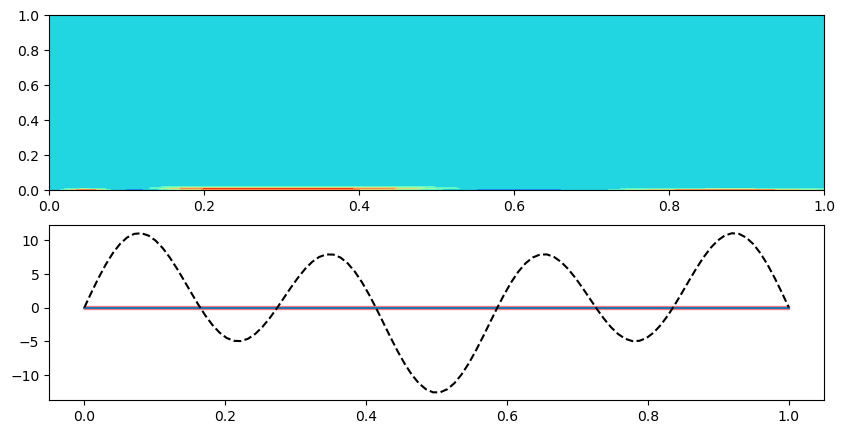

In [38]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
pr =  np.array(0.001)

xx, yy = np.meshgrid(x, y)
xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

X_star = torch.cat([xx,yy,torch.ones_like(xx)*pr],axis = 1)

znn = model_heat(X_star)

xx,yy = np.meshgrid(x, y)

U_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), znn[:,0].detach().numpy().flatten(), (xx,yy), method='cubic')
U_sigma = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), znn[:,1].detach().numpy().flatten(), (xx,yy), method='cubic')
z_exact = exact_solution(xx,yy,pr)

fig, axs = plt.subplots(2,1, figsize=(10, 5))


axs[0].contourf(y, x, U_pred,cmap='rainbow')
axs[1].plot(y,U_pred[10,:])
axs[1].plot(y,z_exact[10,:],linestyle = "--",color = "black", label = "Exact Solution at t = 0 and t = 1.5")

axs[1].fill_between(x.reshape(-1), U_pred[10,:]+U_sigma[10,:],U_pred[10,:]-U_sigma[10,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")

plt.show()